In [1]:
# https://towardsdatascience.com/predicting-airbnb-prices-in-lisbon-trees-and-random-forests-336d19cdf5a2

In [2]:
# https://datasetsearch.research.google.com/search?query=lisbon%20airbnb&docid=c6zMqHvIlOwEwlHEAAAAAA%3D%3D

In [3]:
# https://github.com/josetapadas/airbnb-lisbon-model-trees

In [4]:
# 1. Data exploration and cleanup

In [5]:
import pandas as pd

airbnb_data = pd.read_csv('airbnb_lisbon_1480_2017-07-27.csv')

airbnb_data.columns

Index(['room_id', 'survey_id', 'host_id', 'room_type', 'country', 'city',
       'borough', 'neighborhood', 'reviews', 'overall_satisfaction',
       'accommodates', 'bedrooms', 'bathrooms', 'price', 'minstay', 'name',
       'last_modified', 'latitude', 'longitude', 'location'],
      dtype='object')

In [6]:
airbnb_data.describe()

,room_id,survey_id,host_id,country,borough,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,latitude,longitude
count,1.357800e+04,13578.0,1.357800e+04,0.0,0.0,13578.000000,13578.000000,13578.000000,13578.000000,0.0,13578.000000,0.0,13578.000000,13578.000000
mean,1.128653e+07,1480.0,4.031780e+07,NaN,NaN,29.507512,3.242046,3.872956,1.535793,NaN,88.376712,NaN,38.720882,-9.143594
std,6.331112e+06,0.0,4.120258e+07,NaN,NaN,43.657402,2.151046,2.254779,1.042837,NaN,123.044522,NaN,0.015134,0.017923
min,6.499000e+03,1480.0,1.445500e+04,NaN,NaN,0.000000,0.000000,1.000000,0.000000,NaN,10.000000,NaN,38.692112,-9.226461
25%,5.611757e+06,1480.0,6.855202e+06,NaN,NaN,1.000000,0.000000,2.000000,1.000000,NaN,48.000000,NaN,38.711405,-9.150805
50%,1.253847e+07,1480.0,2.393412e+07,NaN,NaN,11.000000,4.500000,4.000000,1.000000,NaN,70.000000,NaN,38.715857,-9.141973
75%,1.718596e+07,1480.0,6.298880e+07,NaN,NaN,40.000000,5.000000,5.000000,2.000000,NaN,96.000000,NaN,38.726283,-9.132693
max,2.009103e+07,1480.0,1.426582e+08,NaN,NaN,448.000000,5.000000,16.000000,10.000000,NaN,4203.000000,NaN,38.792573,-9.091610


In [7]:
# The price distribution could be represented as follows:

In [9]:
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

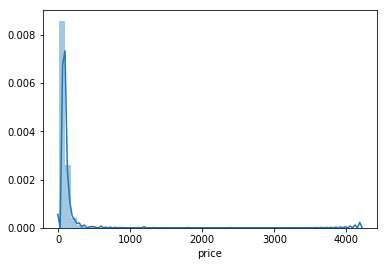

In [12]:
pd.plotting.register_matplotlib_converters() 
sns.distplot(a=airbnb_data['price']);

In [13]:
# Plotting it for where most of the prices reside:

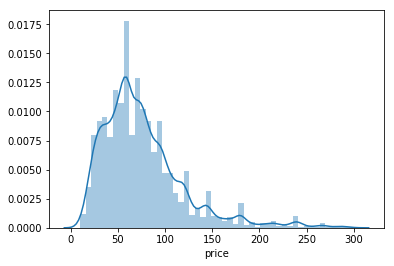

In [14]:
airbnb_sub_set = airbnb_data.loc[airbnb_data.price < 300] 
sns.distplot(a=airbnb_sub_set['price'])

In [15]:
airbnb_data.head()

,room_id,survey_id,host_id,room_type,country,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,name,last_modified,latitude,longitude,location
0,14708916,1480,91501272,Shared room,NaN,Lisbon,NaN,Santo António,19,4.5,4,1.0,NaN,30.0,NaN,LOW COST HOSTEL MARQUES GARDENS 4 BED DORM,2017-07-28 01:19:53.215272,38.723987,-9.146613,0101000020E61000003F56F0DB104B22C055DD239BAB5C...
1,7465447,1480,704061,Shared room,NaN,Lisbon,NaN,Avenidas Novas,4,3.5,6,1.0,NaN,39.0,NaN,Room in Lisbon center,2017-07-28 01:19:53.206052,38.735061,-9.154510,0101000020E610000057CF49EF1B4F22C054C8957A165E...
2,11058290,1480,1379661,Shared room,NaN,Lisbon,NaN,Santa Maria Maior,38,4.5,8,1.0,NaN,39.0,NaN,Bed in a 8-bed dorm @ This Is Lisbon Hostel,2017-07-28 01:19:52.034547,38.715726,-9.132671,0101000020E610000057410C74ED4322C0CD72D9E89C5B...
3,9019111,1480,46762399,Shared room,NaN,Lisbon,NaN,Avenidas Novas,9,4.0,6,1.0,NaN,37.0,NaN,Shared mixed bunkbed room 1,2017-07-28 01:19:52.020396,38.729017,-9.149932,0101000020E61000006C3F19E3C34C22C0309DD66D505D...
4,3123304,1480,8488955,Shared room,NaN,Lisbon,NaN,Arroios,0,0.0,2,1.0,NaN,480.0,NaN,quarto no centro de lisboa,2017-07-28 01:19:50.401364,38.721617,-9.136208,0101000020E61000003AE8120EBD4522C06B9E23F25D5C...


In [16]:
'''
there are empty columns: country, borough, bathrooms, minstay
entries like host_id, survey_id, room_id, name, city, last_modified and survey_id may not be so relevant for our price predictor
there are some categorical data that we will not be able to initially add to the regression of the Price, such as room_type and neighborhood (but we'll be back to these two later on)
location may be redundant for now, when we have both latitude and longitude and we may need to further infer about the nature of the format of this field
'''

"\nthere are empty columns: country, borough, bathrooms, minstay\nentries like host_id, survey_id, room_id, name, city, last_modified and survey_id may not be so relevant for our price predictor\nthere are some categorical data that we will not be able to initially add to the regression of the Price, such as room_type and neighborhood (but we'll be back to these two later on)\nlocation may be redundant for now, when we have both latitude and longitude and we may need to further infer about the nature of the format of this field\n"

In [17]:
lisbon_features = ['reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'latitude', 'longitude']

Y = airbnb_data.price 
X = airbnb_data[lisbon_features]

X.head()

,reviews,overall_satisfaction,accommodates,bedrooms,latitude,longitude
0,19,4.5,4,1.0,38.723987,-9.146613
1,4,3.5,6,1.0,38.735061,-9.154510
2,38,4.5,8,1.0,38.715726,-9.132671
3,9,4.0,6,1.0,38.729017,-9.149932
4,0,0.0,2,1.0,38.721617,-9.136208


In [18]:
# With our new subset, we can now try to understand what is the correlation of these parameters in terms of the overall satisfaction, for the most common price range:

/Users/ryankohanski/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/ryankohanski/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryankohanski/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/ryankohanski/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


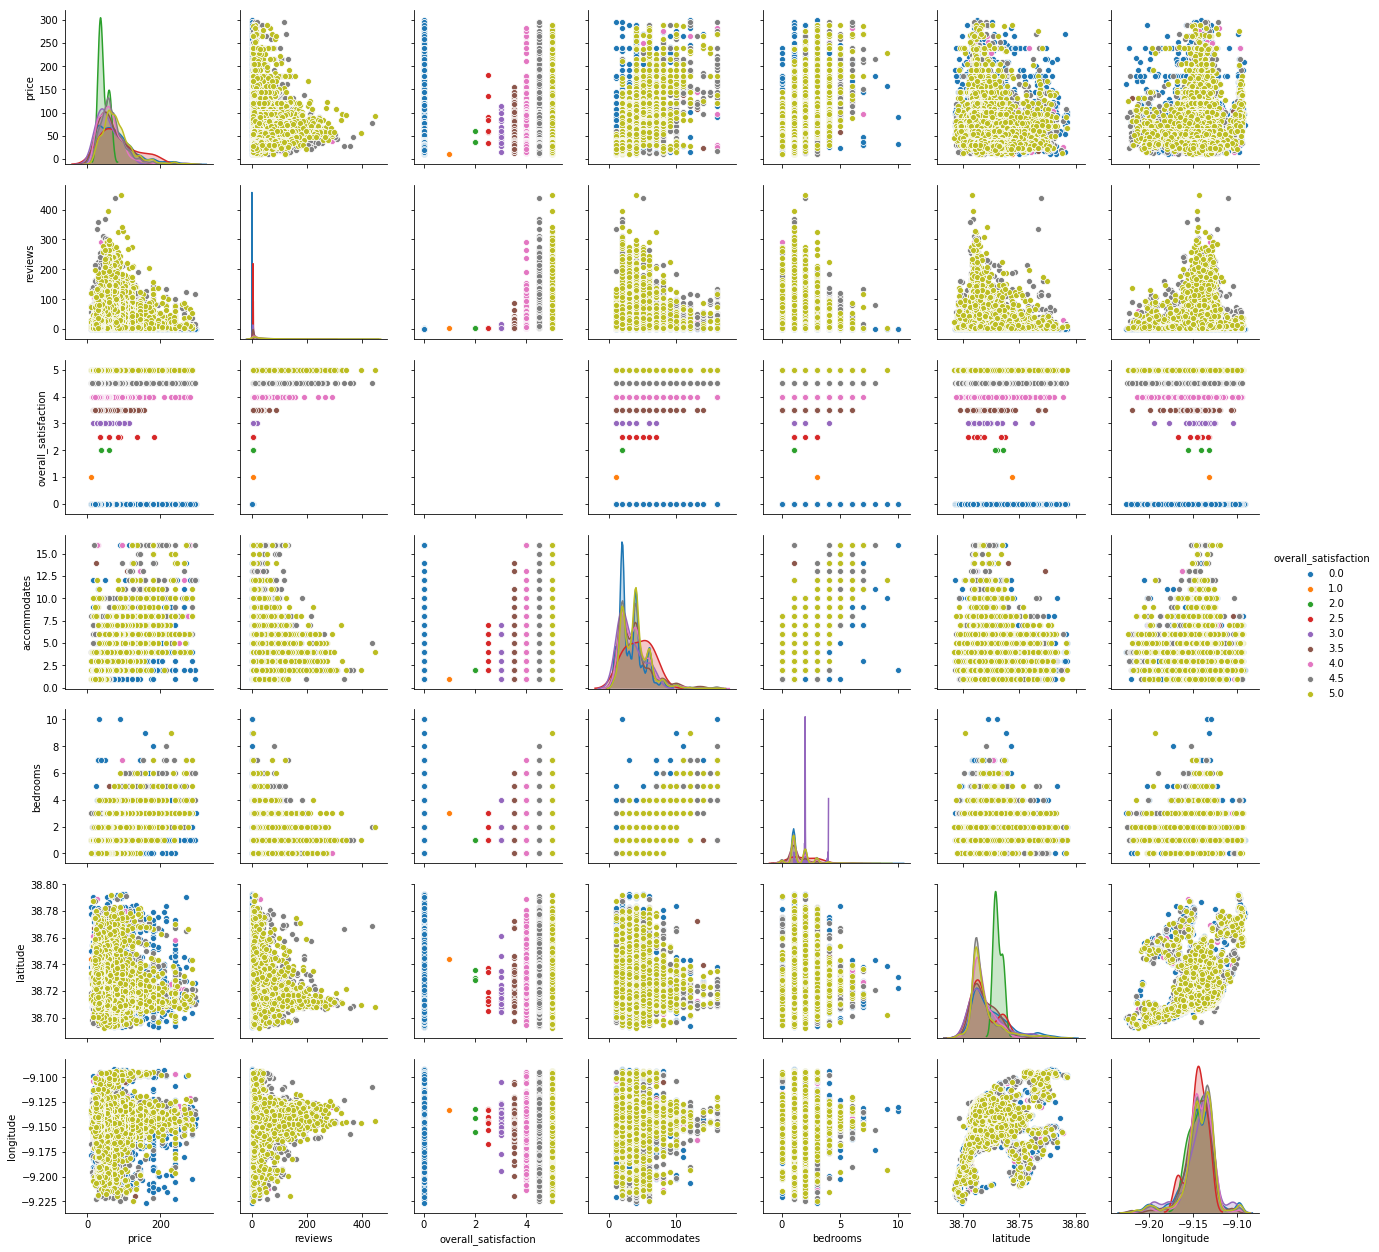

In [19]:
relevant_parameters = ['price'] + lisbon_features

sns.pairplot(airbnb_data.loc[airbnb_data.price < 300][relevant_parameters], hue="overall_satisfaction")

In [20]:
'''
The above plots allow us to check the distribution of all the single variables and try to infer the relationships between them. We’ve taken the freedom to apply a color hue based on the review values for each of our chosen parameters. Some easy reading examples of the above figure, from relationships that may denote a positive correlation:
the number of reviews is more common for rooms with few accommodations. This could mean that most of the guests that review are renting smaller rooms.
most of the reviews are made for the cheaper priced rooms
taking into account the visual dominance of the yellow hue, most of the reviews are actually rated with 5. Either this means that most of the accommodations are actually very satisfactory or, most probably, the large number of people that actually review, do it to give a 5 as the rating.
'''

'\nThe above plots allow us to check the distribution of all the single variables and try to infer the relationships between them. We’ve taken the freedom to apply a color hue based on the review values for each of our chosen parameters. Some easy reading examples of the above figure, from relationships that may denote a positive correlation:\nthe number of reviews is more common for rooms with few accommodations. This could mean that most of the guests that review are renting smaller rooms.\nmost of the reviews are made for the cheaper priced rooms\ntaking into account the visual dominance of the yellow hue, most of the reviews are actually rated with 5. Either this means that most of the accommodations are actually very satisfactory or, most probably, the large number of people that actually review, do it to give a 5 as the rating.\n'

In [21]:
# When plotting both longitude and latitude we can obtain a quasi geographical/spacial distribution for the ratings along Lisbon:

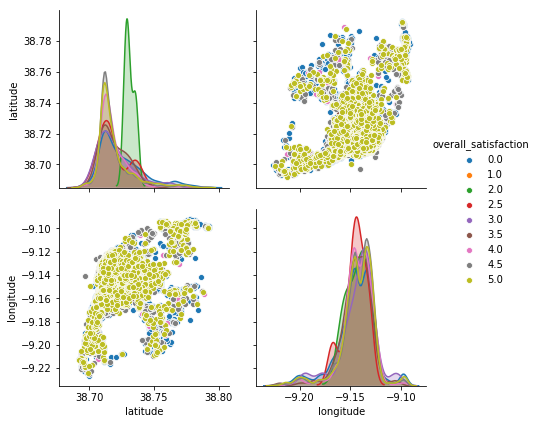

In [22]:
sns.pairplot(airbnb_data, vars=['latitude', 'longitude'], hue="overall_satisfaction", height=3)

In [23]:
# We can then add this data to an actual map of Lisbon, to check the distribution:

In [24]:
'''
As expected, most of the reviews are on the city center with a cluster of reviews already relevant alongside the recent Parque das Nações. The northern more sub-urban area, even though it has some scattered places, the reviews are not as high and common as on the center.
'''

'\nAs expected, most of the reviews are on the city center with a cluster of reviews already relevant alongside the recent Parque das Nações. The northern more sub-urban area, even though it has some scattered places, the reviews are not as high and common as on the center.\n'

In [25]:
# 2. Splitting the dataset

In [26]:
from sklearn.model_selection import train_test_split
train_X, validation_X, train_Y, validation_Y = train_test_split(X, Y, random_state = 42)

print("Training set: Xt:{} Yt:{}".format(train_X.shape, train_Y.shape)) 
print("Validation set: Xv:{} Yv:{}".format(validation_X.shape, validation_Y.shape)) 
print("-") 
print("Full dataset: X:{} Y:{}".format(X.shape, Y.shape))

Training set: Xt:(10183, 6) Yt:(10183,)
Validation set: Xv:(3395, 6) Yv:(3395,)
-
Full dataset: X:(13578, 6) Y:(13578,)


In [27]:
# 3. Planting the Decision Trees

In [28]:
'''
Based on the data, the tree is built on the root and will be (recursively) partitioned by splitting each node into two child ones. These resulting nodes will be split, based on decisions that are inferred about the statistical data we are providing to the model, until we reach a point where the data split results in the biggest information gain, meaning we can properly classify all the samples based on the classes we are iteratively creating. The end vertices we call “leaves”.
'''

'\nBased on the data, the tree is built on the root and will be (recursively) partitioned by splitting each node into two child ones. These resulting nodes will be split, based on decisions that are inferred about the statistical data we are providing to the model, until we reach a point where the data split results in the biggest information gain, meaning we can properly classify all the samples based on the classes we are iteratively creating. The end vertices we call “leaves”.\n'

In [30]:
from sklearn.tree import DecisionTreeRegressor

lisbon_airbnb_model = DecisionTreeRegressor(random_state = 42) 
lisbon_airbnb_model.fit(train_X, train_Y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [35]:
# Generate a visual of the tree
from sklearn.tree import export_graphviz 
from graphviz import Source

export_graphviz(lisbon_airbnb_model, out_file='tree.dot', filled=True, rounded=True, special_characters=True)

from subprocess import call 
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image 
Image(filename = 'tree.png')

FileNotFoundError: [Errno 2] No such file or directory: 'tree.png'

In [36]:
# Predictions
train_X.head()

,reviews,overall_satisfaction,accommodates,bedrooms,latitude,longitude
11956,29,4.5,2,1.0,38.717426,-9.156587
5665,75,5.0,5,2.0,38.716165,-9.144141
11639,2,0.0,3,1.0,38.709567,-9.143207
13391,4,5.0,2,1.0,38.727817,-9.133753
3219,1,0.0,6,3.0,38.723333,-9.130640


In [37]:
lisbon_airbnb_model.predict(train_X.head())

array([ 30.,  81.,  60.,  30., 121.])

In [38]:
# we’ll use the Mean Absolute Error (MAE) metric. We can consider this metric as the average error magnitude in a predictions set

In [39]:
# It is basically an average over the differences between our model predictions (y) and actual observations ( y-hat), making the consideration that all individual differences have equal weight.

In [40]:
from sklearn.metrics import mean_absolute_error

# instruct our model to make predictions for the prices on the validation set 
validation_predictions = lisbon_airbnb_model.predict(validation_X)

# calculate the MAE between the actual prices (in validation_Y) and the predictions made 
validation_prediction_errors = mean_absolute_error(validation_Y, validation_predictions)

validation_prediction_errors

42.91664212076583

In [41]:
'''
This result basically means that our model is giving an absolute error of about 42.935 EUR per accommodation when exposed to the test data, out of a 88.38 EUR mean value that we collected during the initial data exploration.
'''

'\nThis result basically means that our model is giving an absolute error of about 42.935 EUR per accommodation when exposed to the test data, out of a 88.38 EUR mean value that we collected during the initial data exploration.\n'

In [42]:
# As sklearn’s DecisionTreeRegressor allows us to specify a maximum number of leaf nodes as a hyperparameter, let us quickly try to assess if there is a value that decreases our MAE:

In [48]:
# this function takes both the training and validation sets to compute the MAE for a Decision Tree 
def compute_mae(train_X, train_Y, validation_X, validation_Y, max_leaf_nodes): 
  trees_model = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, random_state = 42) 
  trees_model.fit(train_X, train_Y) 
  validation_predictions = trees_model.predict(validation_X) 
  error = mean_absolute_error(validation_Y, validation_predictions)
  
  return(error)

def get_best_tree_size(train_X, train_Y, validation_X, validation_Y, verbose = False):
  # candidates to iterate on finding a better tree depth  
  candidate_max_leaf_nodes = [5, 10, 20, 30, 50, 100, 250, 500]
  
  # initialization 
  minimum_error = None 
  best_tree_size = 5 
  
  # loop to find the minimal error value 
  for max_leaf_nodes in candidate_max_leaf_nodes: 
    current_error = compute_mae(train_X, train_Y, validation_X, validation_Y, max_leaf_nodes) 
    verbose and print("(Size: {}, MAE: {})".format(max_leaf_nodes, current_error)) 
    
    if(minimum_error == None or current_error < minimum_error): 
      minimum_error = current_error 
      best_tree_size = max_leaf_nodes 
     
    return(best_tree_size) 
  
best_tree_size = get_best_tree_size(train_X, train_Y, validation_X, validation_Y, True) 
best_tree_size

(Size: 5, MAE: 42.6016036138866)


5

In [44]:
# Let us then try to generate our model, but including the computed max tree size, and check then its prediction with the new limit:

In [46]:
# create the model
lisbon_airbnb_model = DecisionTreeRegressor(max_leaf_nodes = best_tree_size, random_state = 42)
lisbon_airbnb_model.fit(train_X, train_Y)

# generate the predictions for the validation set
validation_predictions = lisbon_airbnb_model.predict(validation_X)
validation_prediction_errors = mean_absolute_error(validation_Y, validation_predictions)

validation_prediction_errors

42.6016036138866

In [49]:
'''
(Size: 5, MAE: 42.6016036138866) 
(Size: 10, MAE: 40.951013502542885) 
(Size: 20, MAE: 40.00407688450048) 
(Size: 30, MAE: 39.6249335490541) 
(Size: 50, MAE: 39.038730827750555) 
(Size: 100, MAE: 37.72578309289501) 
(Size: 250, MAE: 36.82474862034445) 
(Size: 500, MAE: 37.58889602439078) 250
'''

'\n(Size: 5, MAE: 42.6016036138866) \n(Size: 10, MAE: 40.951013502542885) \n(Size: 20, MAE: 40.00407688450048) \n(Size: 30, MAE: 39.6249335490541) \n(Size: 50, MAE: 39.038730827750555) \n(Size: 100, MAE: 37.72578309289501) \n(Size: 250, MAE: 36.82474862034445) \n(Size: 500, MAE: 37.58889602439078) 250\n'

In [50]:
# So by simply tuning up our maximum number of leaf nodes hyper-parameter we could then obtain a significant increase of our model’s predictions. We have now improved on average ( 42.935 - 36.825) **~ 6.11 EUR** on our model's errors.

In [51]:
# 4. Categorical Data

In [52]:
'''
As mentioned above, even though we are being able to proceed on optimizing our very simplistic model, we still dropped two possible relevant fields that may (or may not) contribute to a better generalization and parameterization of our model: room_type and neighborhood.
'''

'\nAs mentioned above, even though we are being able to proceed on optimizing our very simplistic model, we still dropped two possible relevant fields that may (or may not) contribute to a better generalization and parameterization of our model: room_type and neighborhood.\n'

In [53]:
# 1) Drop

In [54]:
# 2) Label Encoding

In [55]:
'''
So for label encoding, we assume that each value is assigned to a unique integer. We can also make this transformation taking into account any kind of order/magnitude that may be relevant for data (e.g., ratings, views, …).
'''

'\nSo for label encoding, we assume that each value is assigned to a unique integer. We can also make this transformation taking into account any kind of order/magnitude that may be relevant for data (e.g., ratings, views, …).\n'

In [56]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# initialize with a list of values
encoder.fit(["shared room", "single room", "double room", "suite"])

sample_inputs = ["suite", "suite", "shared room", "double room", "single room"]

encoder.transform(sample_inputs)

array([3, 3, 1, 0, 2])

In [57]:
# It is trivial to assess then the transformation that the LabelEncoder is doing, by assigning the array index of the fitted data:

In [58]:
encoder.classes_

array(['double room', 'shared room', 'single room', 'suite'], dtype='<U11')

In [59]:
lisbon_features_extended = ['room_type', 'neighborhood', 'reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'latitude', 'longitude']
X = airbnb_data[lisbon_features_extended]

X.head()

,room_type,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,latitude,longitude
0,Shared room,Santo António,19,4.5,4,1.0,38.723987,-9.146613
1,Shared room,Avenidas Novas,4,3.5,6,1.0,38.735061,-9.154510
2,Shared room,Santa Maria Maior,38,4.5,8,1.0,38.715726,-9.132671
3,Shared room,Avenidas Novas,9,4.0,6,1.0,38.729017,-9.149932
4,Shared room,Arroios,0,0.0,2,1.0,38.721617,-9.136208


In [60]:
# Our categorical data, represented on our panda’s dataframe as an object, can then be extracted by:

In [61]:
categorical = (X.dtypes == 'object')
categorial_columns = list(categorical[categorical].index)

categorial_columns

['room_type', 'neighborhood']

In [62]:
# Now that we have the columns, let us then transform them on both the training and validation sets:

In [63]:
train_X, validation_X, train_Y, validation_Y = train_test_split(X, Y, random_state = 42)

# create copies of our data sets to apply the transformations
train_X_encoded = train_X.copy()
validation_X_encoded = validation_X.copy()

encoder = LabelEncoder()

# for each column we fit the encoder and transform each of the rows
for column in categorial_columns:
    train_X_encoded[column] = encoder.fit_transform(train_X[column])
    validation_X_encoded[column] = encoder.transform(validation_X[column])

# a sample of our transformed data
train_X_encoded.head()

,room_type,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,latitude,longitude
11956,1,9,29,4.5,2,1.0,38.717426,-9.156587
5665,0,21,75,5.0,5,2.0,38.716165,-9.144141
11639,1,15,2,0.0,3,1.0,38.709567,-9.143207
13391,1,4,4,5.0,2,1.0,38.727817,-9.133753
3219,0,18,1,0.0,6,3.0,38.723333,-9.130640


In [64]:
# Let us now train and fit the model with the transformed data:

In [65]:
# compute the best tree size
best_tree_size = get_best_tree_size(train_X_encoded, train_Y, validation_X_encoded, validation_Y)

# create the model
lisbon_airbnb_model = DecisionTreeRegressor(max_leaf_nodes = best_tree_size, random_state = 42)
lisbon_airbnb_model.fit(train_X_encoded, train_Y)

# generate the predictions for the validation set
validation_predictions = lisbon_airbnb_model.predict(validation_X_encoded)
validation_prediction_errors = mean_absolute_error(validation_Y, validation_predictions)

validation_prediction_errors

42.42057729898281

In [66]:
# 35.690195084932355

In [67]:
# 3) One-Hot Encoding

In [68]:
# One-Hot encoding, instead of enumerating a fields’ possible values, create new columns indicating the presence or absence of the encoded values.

In [69]:
from sklearn.preprocessing import OneHotEncoder

# categories
room_type = ["shared room", "single room", "double room", "suite"]
building_type = ["hotel", "apartement", "iglo"]

# initializing the encoder (non-sparse returns an array, and ignore unknown categories)
encoder = OneHotEncoder(categories=[room_type, building_type], sparse=False, handle_unknown='ignore')

# fitting and transforming the example
encoder.fit_transform([['suite', 'iglo'], ['single room', 'apartement']])

array([[0., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1., 0.]])

In [70]:
# From the result above we can see that the binary encoding is providing 1 on the features that each feature array actually has enabled, and 0 when not present. 

In [71]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# create a pandas dataframe with our transformed categorical columns, with One Hot Encoding
train_X_encoded_categories = pd.DataFrame(encoder.fit_transform(train_X[categorial_columns]))
validation_X_encoded_categories = pd.DataFrame(encoder.transform(validation_X[categorial_columns]))

train_X_encoded_categories.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# So the above result may look weird at first but, for the 26 possible categories, we now have a binary codification checking for its presence. 

In [73]:
'''
add back the original row indexes that were lost during the transformation
drop the original categorical columns from the original sets train_X and validation_X
replace the dropped columns by our new dataframe with all 26 possible categories
'''

'\nadd back the original row indexes that were lost during the transformation\ndrop the original categorical columns from the original sets train_X and validation_X\nreplace the dropped columns by our new dataframe with all 26 possible categories\n'

In [74]:
train_X_encoded_categories.index = train_X.index
validation_X_encoded_categories.index = validation_X.index

partial_train_X = train_X.drop(categorial_columns, axis=1)
partial_validation_X = validation_X.drop(categorial_columns, axis=1)

train_X_encoded = pd.concat([partial_train_X, train_X_encoded_categories], axis=1)
validation_X_encoded = pd.concat([partial_validation_X, validation_X_encoded_categories], axis=1)


validation_X_encoded.head()

,reviews,overall_satisfaction,accommodates,bedrooms,latitude,longitude,0,1,2,3,...,17,18,19,20,21,22,23,24,25,26
1061,57,5.0,4,2.0,38.717151,-9.145846,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6480,80,5.0,4,0.0,38.711204,-9.134876,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12233,14,5.0,2,1.0,38.727864,-9.142812,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4659,19,5.0,4,1.0,38.718072,-9.125642,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7383,3,4.0,4,1.0,38.712991,-9.141062,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [75]:
# compute the best tree size
best_tree_size = get_best_tree_size(train_X_encoded, train_Y, validation_X_encoded, validation_Y)

# create the model
lisbon_airbnb_model = DecisionTreeRegressor(max_leaf_nodes = best_tree_size, random_state = 42)
lisbon_airbnb_model.fit(train_X_encoded, train_Y)

# generate the predictions for the validation set
validation_predictions = lisbon_airbnb_model.predict(validation_X_encoded)
validation_prediction_errors = mean_absolute_error(validation_Y, validation_predictions)

validation_prediction_errors

42.79079763192309

In [76]:
# 36.97010930367817

In [77]:
'''
This result may prove that One-Hot-Encoding is not the best fit for both our categorical parameters when compared with the Label Encoding and for both parameters at the same time. 
'''

'\nThis result may prove that One-Hot-Encoding is not the best fit for both our categorical parameters when compared with the Label Encoding and for both parameters at the same time. \n'

In [78]:
# 5. Random Forests

In [79]:
'''
From the previous section we could see that, with our Decision Tree, we are always balancing between:
a deep tree with many leaves, in our case with few AirBnB places on each of them, being then too overfitted to our testing set (they present what we call high variance)
a shallow tree with few leaves that is unable to distinguish between the various features of an item
'''

'\nFrom the previous section we could see that, with our Decision Tree, we are always balancing between:\na deep tree with many leaves, in our case with few AirBnB places on each of them, being then too overfitted to our testing set (they present what we call high variance)\na shallow tree with few leaves that is unable to distinguish between the various features of an item\n'

In [80]:
'''
We can imagine a “Random Forest” as an ensemble of Decision Trees that, in order to try to reduce the variance mentioned above, generates Trees in a way that will allow the algorithm to select the remaining trees in a way that the error is reduced. Some examples of how the random forest is created could be:
generating trees with different subsets of data. For example, from our set of parameters analysed above, trees would be generated having only a random set of them (e.g., a Decision Tree with only “reviews” and “bedrooms”, another with all parameters except “latitude”
generating other trees by training on different samples of data (different sizes, different splits between the data set into training and validation, …)
'''

'\nWe can imagine a “Random Forest” as an ensemble of Decision Trees that, in order to try to reduce the variance mentioned above, generates Trees in a way that will allow the algorithm to select the remaining trees in a way that the error is reduced. Some examples of how the random forest is created could be:\ngenerating trees with different subsets of data. For example, from our set of parameters analysed above, trees would be generated having only a random set of them (e.g., a Decision Tree with only “reviews” and “bedrooms”, another with all parameters except “latitude”\ngenerating other trees by training on different samples of data (different sizes, different splits between the data set into training and validation, …)\n'

In [81]:
'''
In order to reduce the variance, the added randomness makes the generated individual trees’ errors less likely to be related. The prediction is then taken from the average of all predictions, by combining the different decision trees predictions, has the interesting effect of even canceling some of those errors out, reducing then the variance of the whole prediction.
'''

'\nIn order to reduce the variance, the added randomness makes the generated individual trees’ errors less likely to be related. The prediction is then taken from the average of all predictions, by combining the different decision trees predictions, has the interesting effect of even canceling some of those errors out, reducing then the variance of the whole prediction.\n'

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# create copies of our data sets to apply the transformations
train_X_encoded = train_X.copy()
validation_X_encoded = validation_X.copy()

# use the label encoder to our categorical data
encoder = LabelEncoder()

# for each column we fit the encoder and transform each of the rows
for column in categorial_columns:
    train_X_encoded[column] = encoder.fit_transform(train_X[column])
    validation_X_encoded[column] = encoder.transform(validation_X[column])

# let us set a maximum of 250 trees in our forest
airbnb_lisbon_forest_model = RandomForestRegressor(n_estimators = 250, random_state = 42)
airbnb_lisbon_forest_model.fit(train_X_encoded, train_Y)

predictions = airbnb_lisbon_forest_model.predict(validation_X_encoded)

mean_absolute_error(validation_Y, predictions)

33.9996500736377